# Resolutions for Hadron Endcap using single-particle data
## Instructions:
#### 1) Choose angle range, energy, and particle in cell below
#### 2) Set angle filter
#### 3) Set weighting range, draw the histograms and look at the fits.
#### 4) Feel free to change weighting range and initial fit parameters "p0" to get the best fits.
#### 5) Set "draw" to false to go through the entire weighting range
#### 6) Histogram with best resolution is drawn in the next cell

##### Note: Drawing only draws a portion of the weights (first 50 histograms)
##### Note: If you get a numpy warning while fitting, likely need to adjust initial parameters
##### Note: If a drawn histogram doesn't have a fit curve with it, it wasn't able to be fit by a Gaussian. It probably isn't Gaussian in shape, but if it is, can try to play with fit settings.
##### Note: If you get a weird resolution value or your resolution vs weight graph has points not following the trend, likely an issue with the fits of those histograms. 
##### Note: If you're having trouble reading in files, they might not be on the JLab XRootD server. 



In [43]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

### Get data, transform ROOT tree into array

In [44]:
# Parameters 
energy = 1  # Energy in GeV. Available energies are 1, 2, 5, 10, 20, 50 GeV.
particle = 'pi+' # Single particle incident on detectors. Options are e-, gamma, kaon0L, mu-, neutron, pi+, pi0

available_angle_ranges = ["3to50deg", "45to135deg"]
angle_range_select = 0 # Change array index to get desired angle range
angle_range = available_angle_ranges[angle_range_select]
# Code to get all the files from the JLab XRootD server

files = [] # List to contain all the data file names
multiple_files = False # If there are multiple input files or you don't know how many there are, set "multiple_files" to true
if multiple_files:
    max_file_num = 100 # If you know the max file number, change the "max_file_num" to it. This will save a little time while reading the files. Otherwise, just leave it be.
    for file_number in range(1, max_file_num + 1):
        try:
            file_name = 'root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/master/SINGLE/{particle}\
/{energy}GeV/{angle_range}/{particle}_{energy}GeV_{angle_range}.{file_number:04d}.root:events'.format(energy = energy, particle = particle, angle_range = angle_range, file_number = file_number)
            ur.open(file_name) # Open each file. If the file doesn't exist, it will be skipped and not be added to files list.
            files.append(file_name)
        except:
            continue
else:
    files.append('root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/master/SINGLE/{particle}/{energy}GeV/{angle_range}/{particle}_{energy}GeV_{angle_range}.0001.root:events'.format(energy = energy, angle_range = angle_range, particle = particle))

print("Number of files: {NumFiles}".format(NumFiles = len(files)))
if len(files) == 0:
    raise ValueError("No files selected.")
    

# Combining all the data files that we found. Only include the branches/leafs that are of interest
full_events = ur.concatenate(files, ["mcparticles2.ps.x", "mcparticles2.ps.y", "mcparticles2.ps.z", "mcparticles2.pdgID", "mcparticles2.g4Parent"], library = 'np')
EcalP_events = ur.concatenate(files, ["EcalEndcapPHitsReco.energy"], library = 'np')
HcalHadron_events = ur.concatenate(files, ["HcalEndcapPHitsReco.energy"], library = 'np')

Number of files: 1


In [45]:
if len(full_events['mcparticles2.pdgID']) != len(HcalHadron_events["HcalEndcapPHitsReco.energy"]) or len(full_events['mcparticles2.pdgID']) != len(EcalP_events["EcalEndcapPHitsReco.energy"]):
    raise ValueError("Number of events do not align!")
num_events = len(full_events['mcparticles2.pdgID'])
print('Number of events: {events}'.format(events=num_events))

Number of events: 1000002


### Getting the incident angle and momentum for each event

1000002 total events
2 empty events
1000000 nonempty events


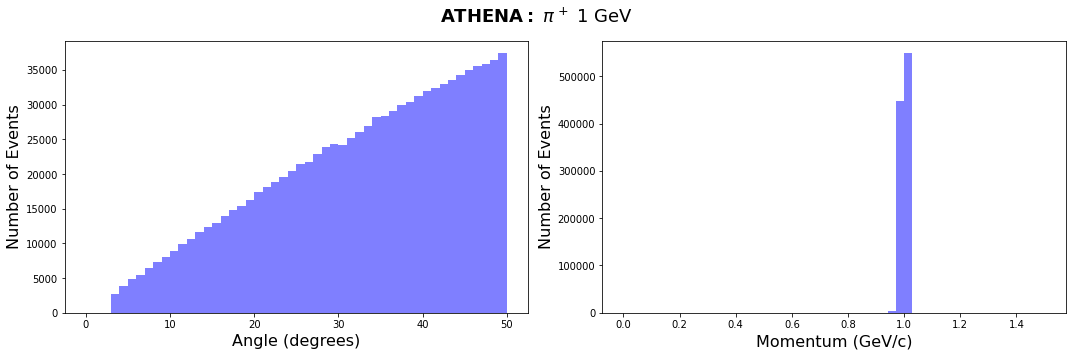

In [106]:
theta_list = []
momentum_list = []
num_empty_events = 0
particle_ids = {'e-':11, 'gamma':22, 'kaon0L':130, 'mu-':13, 'neutron':2112, 'pi+':211, 'pi0':111} # MC particle ids
latex_particles = {'e-':"$e^-$", 'gamma':"$\gamma$", 'kaon0L':"$K^0_L$", 'mu-':"$\mu^-$",'pi+':"$\pi^+$", 'pi0':"$\pi^0$"}

# Looping over each event to get angle and momentum of incident particle
for i in range(num_events):
    num_particles = len(full_events["mcparticles2.pdgID"][i])
    if num_particles == 0:
        num_empty_events += 1
        theta_list.append(-999) # Will count for the total number of events but keeps the empty events out of consideration
        momentum_list.append(-999)
        continue
    for j in range(num_particles):
        if full_events["mcparticles2.pdgID"][i][j] != particle_ids[particle]:
            continue
        if full_events["mcparticles2.g4Parent"][i][j] != 0:
            continue
        px = full_events["mcparticles2.ps.x"][i][j]
        py = full_events["mcparticles2.ps.y"][i][j]
        pz = full_events["mcparticles2.ps.z"][i][j]
        p = np.sqrt(px*px + py*py + pz*pz)
        momentum_list.append(p)
        theta = np.arccos(pz/p)*180/np.pi
        theta_list.append(theta)
        
print("{total} total events".format(total=len(theta_list)))
print("{empty} empty events".format(empty=num_empty_events))
print("{nonempty} nonempty events".format(nonempty=len(theta_list) - num_empty_events))

plt.figure(figsize=(15,5))
plt.suptitle(r"$\bf{ATHENA:}$"+' {particle} {energy} GeV'.format(particle=latex_particles[particle],energy=energy), fontsize=18)

plt.subplot(1,2,1)
if angle_range_select == 0:
    theta_data, theta_bins, _ = plt.hist(theta_list, 50, (0, 50), density=False, facecolor='b', alpha=.5)
elif angle_range_select == 1:
    theta_data, theta_bins, _ = plt.hist(theta_list, 90, (45, 135), density=False, facecolor='b', alpha=.5)
plt.xlabel("Angle (degrees)", fontsize = 16)
plt.ylabel("Number of Events", fontsize = 16)

plt.subplot(1,2,2)
momentum_data, momentum_bins, _ = plt.hist(momentum_list, round(energy+0.5/0.01), (0, energy + 0.5), density=False, facecolor='b',alpha=.5)
plt.xlabel("Momentum (GeV/c)", fontsize = 16)
plt.ylabel("Number of Events", fontsize = 16)
plt.tight_layout()
plt.show()

In [107]:
# Function that chooses events within specific angle range
def Angle_Energy(detector_events = HcalHadron_events, detector_name = "HcalEndcapPHitsReco", event_angles = theta_list, desired_low_angle = 20, desired_high_angle = 21):
    num_events = len(event_angles)
    energies = []
    for i in range(num_events):
        event_angle = event_angles[i]
        if event_angle >= desired_low_angle and event_angle < desired_high_angle:
            energies.append(detector_events["{detector}.energy".format(detector = detector_name)][i])
    return energies

### Filtering angle

In [108]:
# If you want a specific angle range, set filter_angle to True and input angle range into angle variables. Will select events with angles in range [low, high)
filter_angle = True
if filter_angle:
    low_angle = 20
    high_angle = 21
else: # Needed for later plot titles
    if angle_range_select == 0:
        low_angle = 3
        high_angle = 50
    elif angle_range_select == 1:
        low_angle = 45
        high_angle = 145

Hcal_energies = []
Ecal_energies = []
if filter_angle:
    Hcal_energies = Angle_Energy(HcalHadron_events, "HcalEndcapPHitsReco", theta_list, low_angle, high_angle)
    Ecal_energies = Angle_Energy(EcalP_events, "EcalEndcapPHitsReco", theta_list, low_angle, high_angle)
else:
    Hcal_energies = HcalHadron_events["HcalEndcapPHitsReco.energy"]
    Ecal_energies = EcalP_events["EcalEndcapPHitsReco.energy"]

num_desired_events = len(Ecal_energies)
print("Considering {X} events".format(X = num_desired_events))

Considering 17377 events


### Setting up weight histograms

In [109]:
# Weighting the ecal energies and adding to histograms
draw = False # Set to true to draw histograms in next cell

initial_weights_for_energies = {1:1.0, 2:1.5, 5:2.0, 10:4.0, 20:3.0, 50: 4.0} # Below these weights, the histograms aren't Gaussian anymore, making the fits in next cell bad. Feel free to play around with the values.
w0 = initial_weights_for_energies[energy]
max_weight = 15.0 # Arbitrary cutoff, but usually see worse resolution with higher increasing weight above optimal weight.
weights = np.array([],float)
draw_counts = 0

while w0 <= max_weight and draw_counts < 50:
    weights = np.append(weights, w0)
    w0 += 0.1 
    if draw:
        draw_counts += 1 # Will only draw first 50 histograms. Adjust initial weighting and weighting steps to draw the histograms you want. If you want to draw more histograms, adjust max_rows and max_cols in below cell.
        
WEdep = [] # WEdep (weighted Edep) will hold the weighted total energies for each weight in "weights"
for i in range(len(weights)):
    WEdep.append([])
    
for i in range(num_desired_events):
    hcal_edep = np.sum(Hcal_energies[i])*1000 # Convert energy to MeV
    ecal_edep = np.sum(Ecal_energies[i])*1000
    for j in range(len(weights)):
        weighted_energy = ecal_edep/weights[j]+hcal_edep
        WEdep[j].append(weighted_energy)

### Fitting and choosing optimal weight
#### Set "fit" to True to fit, set "draw" to True in cell above to draw sample of histograms from above cell (Warning: Drawing takes a little bit of time)

In [110]:
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, A, mean, variance):
    return A * np.exp( -0.5*( (x - mean)**2 / variance) ) # Make sure to take sqrt of variance parameter to get sigma

max_energies = {1:500, 2:400, 5:800, 10:1000, 20:3000, 50:2500} # Max value of histograms. Based on the data in the drawn histograms. Feel free to adjust 

min_resolution = 999999
min_index = -9999
bin_width = 1 # Each bin will be 1 MeV wide
num_bins = round((max_energies[energy])/bin_width) 
resolutions = np.array([],float) # Will store all resolutions for each weight

print("Number of bins: {bins}".format(bins=num_bins))
print("Bin width: {bin_width} MeV.".format(bin_width=bin_width))

# Parameters for drawing the histograms
max_rows = 10
max_cols = 5

fit = True # True: Histograms are fit with gaussian. False: No fit. Helpful in combination with "draw = True" to look at shape of histograms without fitting
if draw:
    fig = plt.figure(figsize = (40,40))
    fig.subplots_adjust(hspace = .5)

for i in range(0,len(WEdep)):
    if draw: # Drawing the histrogram for each weight
        plt.subplot(max_rows, max_cols, i+1)   
        hist_data, bins, _ = plt.hist(WEdep[i], num_bins, (0, max_energies[energy]))
        plt.title("Weight: {weight_val}".format(weight_val = round(weights[i], 2)))
        plt.xlabel("Energy (MeV)",fontsize = 12)
        plt.ylabel("Number of Events", fontsize = 12)
    else:
        hist_data, bins = np.histogram(WEdep[i], num_bins, (0, max_energies[energy]))

    bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]) # x-value of bin centers

    if fit:
        # Setting initial parameters based on peak of histogram
        amp = 0 # peak amplitude
        amp_x = 0 # x value of peak amplitude
        for k in range(len(hist_data)):
            if hist_data[k] >= amp:
                amp = hist_data[k]
                amp_x = bin_centers[k]
        try:
            popt, pcov = curve_fit(gaussian, xdata=bin_centers, ydata=hist_data, p0=(amp,amp_x, 10))
        except:
            continue # Ignore the histograms that can't be fit by a Gaussian
        weight_resolution = np.sqrt(popt[2])/popt[1]
        resolutions = np.append(resolutions, weight_resolution) # Storing all the resolutions
        if weight_resolution < min_resolution: # Looking for minimum resolution
            min_resolution = weight_resolution
            min_index = i
        if draw:
            plt.plot(bin_centers, gaussian(bin_centers, *popt))
            plt.text(0.8*max_energies[energy], 0.6*amp, "\n A= {amp} \n $\mu$ = {mean} \n $\sigma$ = {sigma} \n $\sigma/\mu$ = {res}"\
                     .format(amp = round(popt[0],2), mean = round(popt[1],2), sigma = round(np.sqrt(popt[2]),3), res = round(weight_resolution,4)),horizontalalignment='center',multialignment='left',verticalalignment='center', fontsize = 16)

if fit:
    print("Index of best weight in WEdep list: {index}".format(index = min_index))
    print("Minimum resolution is {res} using weight {weight}.".format(res = round(min_resolution,3), weight = round(weights[min_index],2)))

Number of bins: 500
Bin width: 1 MeV.
Index of best weight in WEdep list: 92
Minimum resolution is 0.241 using weight 10.2.


### Plotting the histogram with the optimal weight


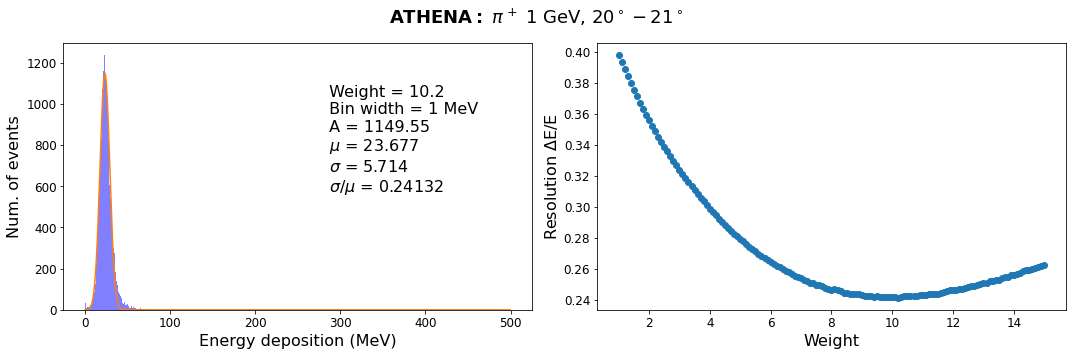

In [111]:
fig = plt.figure(figsize=(15,5))

fig.suptitle(r"$\bf{ATHENA:}$"+' {particle} {energy} GeV, ${low_angle}^{degrees}-{high_angle}^{degrees}$'.format(particle=latex_particles[particle], energy=energy, low_angle = low_angle, high_angle = high_angle, degrees = "\circ"), fontsize=18)

plt.subplot(1,2,2)
plt.scatter(weights, resolutions)
plt.xlabel("Weight", fontsize = 16)
plt.ylabel("Resolution $\Delta$E/E", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,1)
hist_data, bins, _ = plt.hist(WEdep[min_index], num_bins, (0, max_energies[energy]), density=False, facecolor='b', alpha=.5)

bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
amp = 0
amp_x = 0
for i in range(len(hist_data)):
    if hist_data[i] >= amp:
        amp = hist_data[i]
        amp_x = bin_centers[i]
popt, pcov = curve_fit(gaussian, xdata=bin_centers, ydata=hist_data, p0=(amp,amp_x,10))

plt.plot(bin_centers, gaussian(bin_centers, *popt))
plt.xlabel("Energy deposition (MeV)", fontsize = 16)
plt.ylabel("Num. of events", fontsize = 16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.75*max_energies[energy], 0.7*amp, "\n Weight = {weight} \n Bin width = {width} MeV \n A = {amplitude} \n $\mu$ = {mean} \n $\sigma$ = {sigma} \n $\sigma/\mu$ = {res}".format(weight = round(weights[min_index],2), width = bin_width ,amplitude = round(popt[0],2), mean = round(popt[1],3), sigma = round(np.sqrt(popt[2]),3), res = round(np.sqrt(popt[2])/popt[1],5)),horizontalalignment='center',multialignment='left',
                 verticalalignment='center', fontsize = 16)
plt.tight_layout()